# Fuga de clientes

Los clientes comenzaron a salir «Beta-Bank» cada mes. Un poco, pero notable. Los vendedores del banco lo consideraron más barato mantener a clientes actuales que atraer nuevos.

Tenemos que predecir si el cliente dejará el banco pronto o no. Se le proporcionan datos históricos sobre el comportamiento del cliente y la terminación de los contratos con el banco. 

Cree un modelo con un valor límite de *F1*-medidas. Para tener éxito, debe llevar la métrica a 0,59. Compruebe usted mismo la medida *F1*de la muestra.

Medida adicional *AUC-ROC*, comparar su valor con la medida *F1*.

Fuente de datos: [https://www.kaggle.com/barelydedicated/bank-customerchurn-modeling](https://www.kaggle.com/lywdedicated/bank-bare-churncustoming)

## Preparación de datos

Cargue los módulos requeridos.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

Abramos y estudiemos el conjunto de datos.

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
print(data.head(10))
data.info()

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   
5          6    15574012       Chu          645     Spain    Male   44   
6          7    15592531  Bartlett          822    France    Male   50   
7          8    15656148    Obinna          376   Germany  Female   29   
8          9    15792365        He          501    France    Male   44   
9         10    15592389        H?          684    France    Male   27   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0       

Tenemos las siguientes características:  
RowNumber - un índice de cadena en los datos  
CustomerId - ID de cliente único  
Apellido - apellido  
CreditScore - calificación crediticia  
Geografía - país de residencia  
Género - Género  
Edad - Edad  
Tenencia - cuántos años una persona es cliente de un banco  
Saldo - saldo de la cuenta  
NumOfProducts - el número de productos bancarios utilizados por el cliente  
HasCrCard - disponibilidad de tarjeta de crédito  
IsActiveMember - actividad del cliente  
EstimadoSalary - salario previsto  

#### Procesamiento de pases
En el bloque de información vemos que solo hay un signo - "¿Cuántos años es un cliente". Lógicamente, supongamos que los valores se omiten para los clientes que han estado usando servicios durante menos de 1 año, por lo que podemos reemplazar las omisiones con ceros.

In [4]:
data['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [5]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())

In [6]:
check_mean_df = pd.read_csv('/datasets/Churn.csv')

check_mean_df['Tenure'].mean()

4.997690023099769

### Comprobar si hay duplicados

In [7]:
data.duplicated().sum()

0

No hay duplicados obvios.

### Trabajar con tipos de datos

Veamos si todos los tipos de datos son correctos.  
Usted debe reemplazar la tenencia con int.  
Características HasCrCard, IsActiveMember, Exited - on Boolean type, porque tienen los valores de 1 o 0. Los valores de los atributos son los mismos.

In [8]:
for column in data[['Tenure']]:
    data[column] = data[column].astype("int")
    
for column in data[['HasCrCard', 'IsActiveMember', 'Exited']]:
    data[column] = data[column].astype("bool")

### Trabajo destacado

Haremos un nuevo dataframe para el aprendizaje automático. No necesitamos las primeras tres columnas ( , ID y apellido para las predicciones - que no afectan a la salida de los clientes, eliminarlos).

In [9]:
drop = ['RowNumber','CustomerId', 'Surname']
data_ml = data.drop(drop, axis=1)

Utilizamos el método OHE para evitar atrapar la trampa.

In [10]:
data_ml = pd.get_dummies(data_ml, drop_first=True)
data_ml.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,True,True,101348.88,True,0,0,0
1,608,41,1,83807.86,1,False,True,112542.58,False,0,1,0
2,502,42,8,159660.80,3,True,False,113931.57,True,0,0,0
3,699,39,1,0.00,2,False,False,93826.63,False,0,0,0
4,850,43,2,125510.82,1,True,True,79084.10,False,0,1,0
5,645,44,8,113755.78,2,True,False,149756.71,True,0,1,1
6,822,50,7,0.00,2,True,True,10062.80,False,0,0,1
7,376,29,4,115046.74,4,True,False,119346.88,True,1,0,0
8,501,44,4,142051.07,2,False,True,74940.50,False,0,0,1
9,684,27,2,134603.88,1,True,True,71725.73,False,0,0,1


### Separación por muestreo

Creamos muestras de entrenamiento, validación y pruebas.

In [11]:
features = data_ml.drop(['Exited'], axis=1)
target = data_ml['Exited'] 

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_test, target_test, test_size=0.5, random_state=12345) 

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)
print(features_valid.shape)
print(target_valid.shape)

(6000, 11)
(6000,)
(2000, 11)
(2000,)
(2000, 11)
(2000,)


Para ampliar el método del escalador, fije las características numéricas.

In [12]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

Escala los números de las tres muestras.

In [13]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Los datos están totalmente disponibles para la investigación.

## Task Research

### Aprendizaje automático

#### DecisionTreeClassifier

In [14]:
best_f1 = 0

for depth in range(1,10,1):
    model_tree=DecisionTreeClassifier(max_depth=depth,random_state=12345).fit(features_train,target_train)
    prediction=model_tree.predict(features_valid)
    f1 = f1_score(target_valid, prediction)
    if f1 > best_f1:
        best_model = model_tree
        best_f1 = f1
        best_depth = depth
        
probabilities_one_valid = best_model.predict_proba(features_valid)[:, 1]
best_roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
print('Max depth', best_depth)
print('F1', best_f1)
print('AUC-ROC', best_roc_auc)

Max depth 6
F1 0.5696969696969697
AUC-ROC 0.8164631712023421


#### RandomForestClassifier

In [15]:
best_f1 = 0

for max_depth in range(1,20,1):
    model_forest=RandomForestClassifier(max_depth=max_depth,n_estimators=50,random_state=12345).fit(features_train,target_train)
    prediction=model_forest.predict(features_valid)
    f1 = f1_score(target_valid, prediction)
    if f1 > best_f1:
        best_depth = max_depth
        best_f1 = f1
    
for estim in range(1,50,2):
    model_forest=RandomForestClassifier(max_depth=11,n_estimators=estim,random_state=12345).fit(features_train,target_train)
    prediction=model_forest.predict(features_valid)
    f1 = f1_score(target_valid, prediction)
    if f1 > best_f1:
        best_estim = estim
        best_f1 = f1
    
print('best n_estimators =', 
      best_estim, 
      '; ',
      'best max_depth =', 
      best_depth, 
      '; ', 
      'best F1 = ', 
      f1_score(target_valid,prediction), 
      end =''
     ) 

probabilities_one_valid = best_model.predict_proba(features_valid)[:, 1]
best_roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
print('; AUC-ROC', best_roc_auc)

best n_estimators = 7 ;  best max_depth = 19 ;  best F1 =  0.5766871165644172; AUC-ROC 0.8164631712023421


#### Logistic Regression

In [16]:
model_logistic=LogisticRegression().fit(features_train,target_train)
prediction=model_logistic.predict(features_valid)
print('F1:',f1_score(target_valid,prediction))

F1: 0.33108108108108103


El resultado - la precisión más alta (0.578) mostró el modelo "Bosque aleatorio" con hiperparámetros Número de árboles - 7, Profundidad del árbol - 19.

### Clases de equilibrio

Estamos explorando el equilibrio de clases.

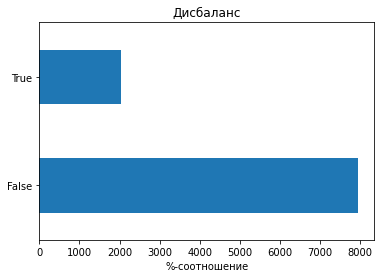

In [17]:
target_train.value_counts(normalize = True)
target.value_counts().plot.barh()
plt.xlabel("%-соотношение")
_ = plt.title("Дисбаланс")

Hay un desequilibrio. Valores falsos del 80% y 20% verdaderos. Es probable que los resultados de las predicciones se inclinen fuertemente hacia una opción.

### Garantía de calidad de los modelos antes del equilibrio

In [18]:
# Integridad, precisión y función de aprendizaje F1-medida
def rec_prec_f1(target_valid, prediction):
    print("Полнота" , recall_score(target_valid, prediction))
    print("Точность", precision_score(target_valid, prediction))
    print("F1-мера", f1_score(target_valid, prediction))

In [19]:
# Función para mostrar la relación de respuesta de los modelos (cuánto 0, cuánto 1)
def all_models_share(features_train, target_train, features_valid, target_valid):
    model_DTC = DecisionTreeClassifier(max_depth=6,random_state=12345)
    model_DTC.fit(features_train, target_train)
    DTC_share = pd.Series(model_DTC.predict(features_valid)).value_counts(normalize = 1)
    
    model_RFC = RandomForestClassifier(random_state=12345, n_estimators=19, max_depth = 7)
    model_RFC.fit(features_train, target_train)
    RFC_share = pd.Series(model_RFC.predict(features_valid)).value_counts(normalize = 1)
    
    model_LgR = LogisticRegression(solver = 'liblinear')
    model_LgR.fit(features_train, target_train)
    LgR_share = pd.Series(model_LgR.predict(features_valid)).value_counts(normalize = 1)
    
    print("Доли ответов:", "Дерево решений", DTC_share, "Случайный лес ", RFC_share, "Логистическая регрессия", LgR_share , end='')

In [20]:
all_models_share(features_train, target_train, features_valid, target_valid)

Доли ответов: Дерево решений False    0.879
True     0.121
dtype: float64 Случайный лес  False    0.8845
True     0.1155
dtype: float64 Логистическая регрессия False    0.913
True     0.087
dtype: float64

Vamos a comparar la calidad de las predicciones con el modelo constante, tomando un valor constante de 0.

In [21]:
target_predict_constant = pd.Series([0]*len(target_valid))
target_predict_constant.shape

(2000,)

In [22]:
accuracy_score_constant = accuracy_score(target_valid, target_predict_constant)
accuracy_score_constant

0.791

Precisión del modelo constante - 0.791
Construimos matrices de errores para cada modelo.

#### Matriz de errores del árbol de decisiones

In [23]:
model_DTC = DecisionTreeClassifier(max_depth=6,random_state=12345)
model_DTC.fit(features_train, target_train)
DTC_prediction = model_DTC.predict(features_valid)
confusion_matrix(target_valid, DTC_prediction)

array([[1528,   54],
       [ 230,  188]])

Predicciones más falsamente positivas (FP).

Vamos a evaluar la integridad, precisión y F1-medida.

In [24]:
print("Полнота" , recall_score(target_valid, prediction))
print("Точность", precision_score(target_valid, prediction))
print("F1-мера", f1_score(target_valid, prediction))
predicted = model_DTC.predict(features_valid)
proba = model_DTC.predict_proba(features_valid)
proba_one = proba[:, 1]    
auc_roc = roc_auc_score(target_valid, proba_one)
print("AUC-ROC", auc_roc)

Полнота 0.23444976076555024
Точность 0.5632183908045977
F1-мера 0.33108108108108103
AUC-ROC 0.8164631712023421


El bajo valor F1 indica un modelo de baja calidad - el problema es la precisión.

Calcularemos AUC-ROC y construiremos una curva ROC.

In [25]:
DTC_probabilities_one_valid = model_DTC.predict_proba(features_valid)[:, 1]
auc_roc_DTC = roc_auc_score(target_valid, DTC_probabilities_one_valid)
auc_roc_DTC

0.8164631712023421

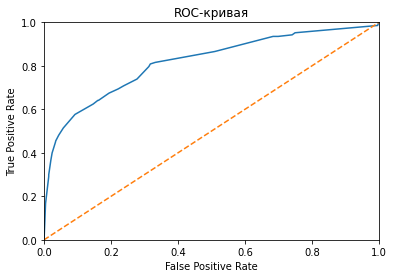

In [26]:
fpr, tpr, thresholds = roc_curve(target_valid, DTC_probabilities_one_valid) 
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

#### Matriz aleatoria de errores forestales

In [27]:
model_RFC = RandomForestClassifier(random_state=12345, n_estimators=19, max_depth = 7)
model_RFC.fit(features_train, target_train)
RFC_prediction = model_RFC.predict(features_valid)
confusion_matrix(target_valid, RFC_prediction)

array([[1534,   48],
       [ 235,  183]])

De nuevo, los valores están fuertemente inclinados hacia el falso positivo (FP).

In [28]:
print("Полнота" , recall_score(target_valid, prediction))
print("Точность", precision_score(target_valid, prediction))
print("F1-мера", f1_score(target_valid, prediction))
predicted = model_RFC.predict(features_valid)
proba = model_RFC.predict_proba(features_valid)
proba_one = proba[:, 1]    
auc_roc = roc_auc_score(target_valid, proba_one)
print("AUC-ROC", auc_roc)

Полнота 0.23444976076555024
Точность 0.5632183908045977
F1-мера 0.33108108108108103
AUC-ROC 0.8452038180729378


El valor F1 es bajo de nuevo, el problema es la precisión.

In [29]:
RFC_probabilities_one_valid = model_RFC.predict_proba(features_valid)[:, 1]
auc_roc_RFC = roc_auc_score(target_valid, RFC_probabilities_one_valid)
auc_roc_RFC

0.8452038180729378

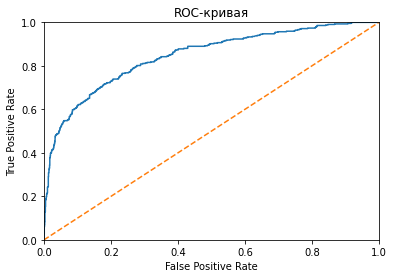

In [30]:
fpr, tpr, thresholds = roc_curve(target_valid, RFC_probabilities_one_valid) 
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

#### Matriz de errores de regresión logística

Score 0.8425
AUC-ROC 0.7999488866978387


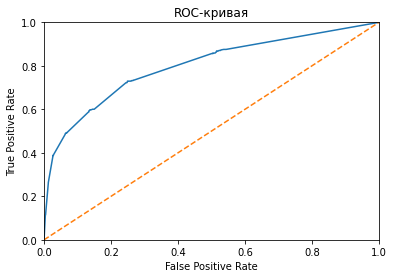

In [31]:
model_RFC = RandomForestClassifier(max_depth=19,n_estimators=7,random_state=12345)
model_RFC.fit(features_train, target_train)
RFC_probabilities_one_valid_class_weight = model_RFC.predict_proba(features_valid)[:, 1]
print("Score", model_RFC.score(features_valid, target_valid))
print("AUC-ROC", roc_auc_score(target_valid, RFC_probabilities_one_valid_class_weight))

fpr, tpr, thresholds = roc_curve(target_valid, RFC_probabilities_one_valid_class_weight) 
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [32]:
model_LgR = LogisticRegression(solver = 'liblinear')
model_LgR.fit(features_train, target_train)
LgR_prediction = model_LgR.predict(features_valid)
confusion_matrix(target_valid, LgR_prediction)

array([[1506,   76],
       [ 320,   98]])

In [33]:
print("Полнота" , recall_score(target_valid, prediction))
print("Точность", precision_score(target_valid, prediction))
print("F1-мера", f1_score(target_valid, prediction))
predicted = model_LgR.predict(features_valid)
proba = model_LgR.predict_proba(features_valid)
proba_one = proba[:, 1]    
auc_roc = roc_auc_score(target_valid, proba_one)
print("AUC-ROC", auc_roc)

Полнота 0.23444976076555024
Точность 0.5632183908045977
F1-мера 0.33108108108108103
AUC-ROC 0.7587512627102753


En este caso, considere la métrica AUC-ROC.

In [34]:
LgR_probabilities_one_valid = model_LgR.predict_proba(features_valid)[:, 1]
auc_roc_LgR = roc_auc_score(target_valid, LgR_probabilities_one_valid)
auc_roc_LgR

0.7587512627102753

Construye una curva ROC.

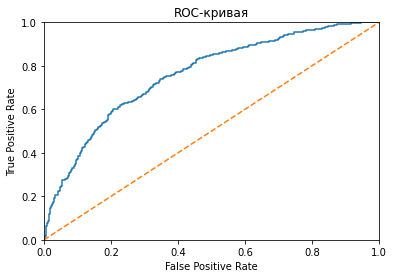

In [35]:
fpr, tpr, thresholds = roc_curve(target_valid, LgR_probabilities_one_valid) 
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

La precisión de las predicciones no ha mejorado. 

La alta precisión del modelo puede explicarse por la alta tasa de respuesta negativa en la muestra de validación.

## Reequilibrio

### Técnica de ampliación

Vamos a construir un modelo de regresión logística, teniendo en cuenta el desequilibrio, utilizando el muestreo ascendente.

In [36]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
  
    return features_upsampled, target_upsampled

In [37]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4) # применим upsampling
features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345) # перемешаем строки
model_lr_up = LogisticRegression(random_state=12345) # инициируем модель ЛР
model_lr_up.fit(features_upsampled, target_upsampled) # обучим модель

LogisticRegression(random_state=12345)

In [38]:
predicted_valid_up = model_lr_up.predict(features_valid) # спрогнозируем целевой параметр
f1_score(predicted_valid_up, target_valid) # получим критерий f1

0.4888507718696398

In [39]:
predicted = model_lr_up.predict(features_valid)
proba = model_lr_up.predict_proba(features_valid)
proba_one = proba[:, 1]    
auc_roc = roc_auc_score(target_valid, proba_one)
print("AUC-ROC", auc_roc)

AUC-ROC 0.7636206364664678


La técnica de upsampling aumentó F1 para la regresión logística. Para futuras previsiones, utilizaremos las características de los datos obtenidos, ampliadas y con objetivos ampliados.

### Cómo equilibrar los pesos de las clases

In [40]:
model_lr_balanced = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_lr_balanced.fit(features_train, target_train) # обучим модель

LogisticRegression(class_weight='balanced', random_state=12345,
                   solver='liblinear')

In [41]:
predicted_valid_balanced = model_lr_balanced.predict(features_valid) # спрогнозируем целевой параметр
f1_score(predicted_valid_balanced, target_valid) # получим критерий f1

0.4888507718696398

In [42]:
predicted = model_lr_balanced.predict(features_valid)
proba = model_lr_balanced.predict_proba(features_valid)
proba_one = proba[:, 1]    
auc_roc = roc_auc_score(target_valid, proba_one)
print("AUC-ROC", auc_roc)

AUC-ROC 0.7637310291013133


El resultado de F1 es el mismo que upsampling.

### Select Model

In [43]:
# Decision tree

model_dt = DecisionTreeClassifier(max_depth=6,random_state=12345)
model_dt.fit(features_upsampled, target_upsampled) 
predicted_valid_dt = model_dt.predict(features_valid) 
f1_score(predicted_valid_dt, target_valid) 

0.5581835383159887

In [44]:
# RandomForest

model_rf = RandomForestClassifier(random_state=12345, n_estimators=19, max_depth = 7)
model_rf.fit(features_upsampled, target_upsampled) 
predicted_valid_rf = model_rf.predict(features_valid) 
f1_score(predicted_valid_rf, target_valid) 

0.6156941649899397

En el modelo Random Forest ya hemos conseguido una medida de al menos 0,59. Además, volveremos a comprobar los hiperparámetros.

In [45]:
df_result = pd.DataFrame(columns=['depth', 'n_est', 'f1'])
for n_est in range(10, 101, 10):
    for depth in range(1, 25, 5):
        model = RandomForestClassifier(n_estimators=n_est, max_depth=depth, random_state=12345)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(predicted_valid, target_valid)
        new_row = pd.Series(data={'depth': depth, 'n_est': n_est, 'f1': f1})
        df_result = df_result.append(new_row,ignore_index=True)
        
df_result.head()

,depth,n_est,f1
0,1.0,10.0,0.515917
1,6.0,10.0,0.588694
2,11.0,10.0,0.595023
3,16.0,10.0,0.575064
4,21.0,10.0,0.569892


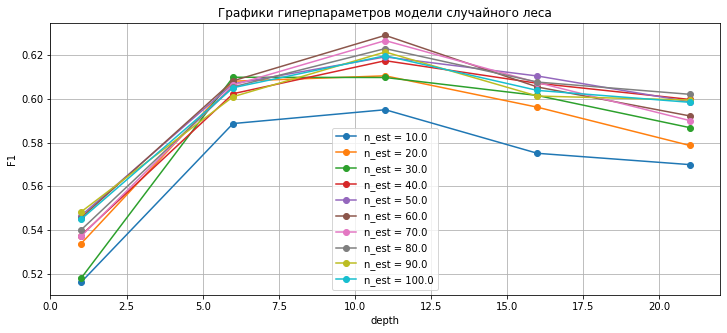

Наилучший показатель f1 0.619750283768445


In [46]:
fig, ax = plt.subplots()
for i in df_result['n_est'].unique():
    df_result[df_result['n_est'] == i].plot(x = 'depth', y = 'f1', ax=ax, style='o-', \
                                             grid=True, figsize=(12, 5), legend=True, label='n_est = %s'%i)
plt.title('Графики гиперпараметров модели случайного леса')
plt.ylabel('F1')
plt.show()

print('Наилучший показатель f1', float(df_result[(df_result['n_est'] == 100) & (df_result['depth'] == 11)]['f1']))

El mejor valor de F1 0.619 fue en hiperparámetros Número de árboles = 60 y Profundidad del árbol = 11.

## Ensayo de modelos

Entrenemos al modelo final.

In [47]:
model_RFC_final = RandomForestClassifier(
    bootstrap = True, class_weight = 'balanced', max_depth= 11,  n_estimators = 60, random_state=12345)
model_RFC_final.fit(features_upsampled, target_upsampled)

RandomForestClassifier(class_weight='balanced', max_depth=11, n_estimators=60,
                       random_state=12345)

In [48]:
model_RFC_final_prediction = model_RFC_final.predict(features_test)
rec_prec_f1(target_test, model_RFC_final_prediction)

Полнота 0.6359338061465721
Точность 0.578494623655914
F1-мера 0.6058558558558559


Calcularemos en la muestra de prueba AUC-ROC para RFC.

In [49]:
model_RFC_final_valid = model_RFC_final.predict_proba(features_test)[:, 1]
auc_roc_RFC = roc_auc_score(target_test, model_RFC_final_valid)
auc_roc_RFC

0.8521161915298371

Crea un patrón constante.

In [50]:
target_predict_constant = pd.Series([0]*len(target_test))
target_predict_constant.value_counts()

0    2000
dtype: int64

Compare la precisión (exactitud) de los modelos constantes y finales, y luego compare AUC-ROC - el único parámetro que se puede comparar, porque la división constante contiene solo respuestas negativas.

In [51]:
print('accuracy_score константой модели:', accuracy_score(target_valid, target_predict_constant))
print('accuracy_score финальной модели:', accuracy_score(target_test, model_RFC_final_prediction))
print('AUC-ROC константой модели:', roc_auc_score(target_valid, target_predict_constant))
print('AUC-ROC финальной модели:', roc_auc_score(target_test, model_RFC_final_valid))

accuracy_score константой модели: 0.791
accuracy_score финальной модели: 0.825
AUC-ROC константой модели: 0.5
AUC-ROC финальной модели: 0.8521161915298371


El modelo final muestra los resultados por encima de la constante - se puede considerar adecuado!

## Pines

En los datos iniciales hubo un fuerte desequilibrio de respuestas: 80% negativo y solo 20% positivo, por lo que el modelo no fue probado para adecuación. Todos los modelos con estos datos eran de baja calidad F1 y mostraron bajos resultados de precisión e integridad.

Hemos intentado dos maneras de corregir el desequilibrio: aumentando y equilibrando los pesos de clase. Ambas variantes dieron F1 = 0,49, y el número de valores positivos se incrementó.

Con los nuevos datos, los resultados del modelo fueron más altos, lo mejor del modelo de Bosque Aleatorio en el modelo de prueba f1 = 0.605 a Profundidad de Árbol = 11 y Número de Árboles = 60.

El modelo final pasó la prueba de adecuación, mostrando valores por encima del modelo constante:
Relación de respuestas correctas modelo constante: 0.791
Tasa de respuesta final del modelo: 0,825

Además, se construyó la curva ROC y se midió el AUC-ROC = 0,852.